# Exercises-MRI-segmentation

Coding exercises for appying to the position at the Paris Brain Institute. The base code is taken from the following tutorial: https://colab.research.google.com/github/fepegar/torchio-notebooks/blob/main/notebooks/TorchIO_MONAI_PyTorch_Lightning.ipynb#scrollTo=QixbF3koO99H. 

# Imports, configuration dict and data preparation

In [3]:
# imports
import torch
import monai

from utils.plotting import plot_image_label
from utils.trainer_class import Trainer
from utils.data_class import MedicalDecathlonDataModule
from utils.other_utils import assert_config

%load_ext autoreload
%autoreload 2

c:\Users\simon\anaconda3.gz\envs\torch-v2-gpu\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# config file for hyperparameters
config = {
    "task": "Task04_Hippocampus",
    "google_id": "1RzPB1_bqzQhlWvU-YGvZzhx2omcDh38C",
    "batch_size": 16,  # batch size for the training
    "train_val_ratio": 0.8,  # ratio of training samples to validation samples
    "epochs": 10,  # number of epochs for the training
    "lr": 1e-2,  # learning rate
    "early_stopping": -1,  # -1 to disable, else insert patience
    "mixed_precision": True,  # True to use mixed precision, else False
    "Nit": 8,  # number of iterations for the training loop, None if you want to do all
    "train_from_checkpoint": None,  # None to train from scratch, else insert path to the model weights
    "fine_tune": False,  # True to fine-tune the model, else False to train from scratch
    "best_models_dir": "best_models",  # directory where the best models will be saved
    "random_seed": 42,  # random seed for reproducibility
}

assert_config(config)

print(f"Config file parameters:")
for key, value in config.items():
    print(f"  -{key}: {value}")

Config file parameters:
  -task: Task04_Hippocampus
  -google_id: 1RzPB1_bqzQhlWvU-YGvZzhx2omcDh38C
  -batch_size: 16
  -train_val_ratio: 0.8
  -epochs: 10
  -lr: 0.01
  -early_stopping: -1
  -mixed_precision: True
  -Nit: 8
  -train_from_checkpoint: None
  -fine_tune: False
  -best_models_dir: best_models
  -random_seed: 42


In [5]:
# set the random seed
torch.manual_seed(config["random_seed"])
print(f"Random seed set to {config['random_seed']}")

# data download & preparation
data = MedicalDecathlonDataModule(
    task=config["task"],
    google_id=config["google_id"],
    batch_size=config["batch_size"],
    train_val_ratio=config["train_val_ratio"],
)

data.prepare_data()
data.setup()

train_data_loader = data.train_dataloader()
val_data_loader = data.val_dataloader()
test_data_loader = data.test_dataloader()

Random seed set to 42


In [6]:
print(f"\nTraining samples: {len(data.train_set)}")
print(f"Train data loader length: {len(train_data_loader)}")

print(f"\nValidation samples: {len(data.val_set)}")
print(f"Val data loader length: {len(val_data_loader)}")

print(f"\nTest samples: {len(data.test_set)}")
print(f"Test data loader length: {len(test_data_loader)}")


Training samples: 208
Train data loader length: 13

Validation samples: 52
Val data loader length: 4

Test samples: 130
Test data loader length: 9


# Visualize a training sample

The shape of the data is torch.Size([16, 1, 48, 64, 48])


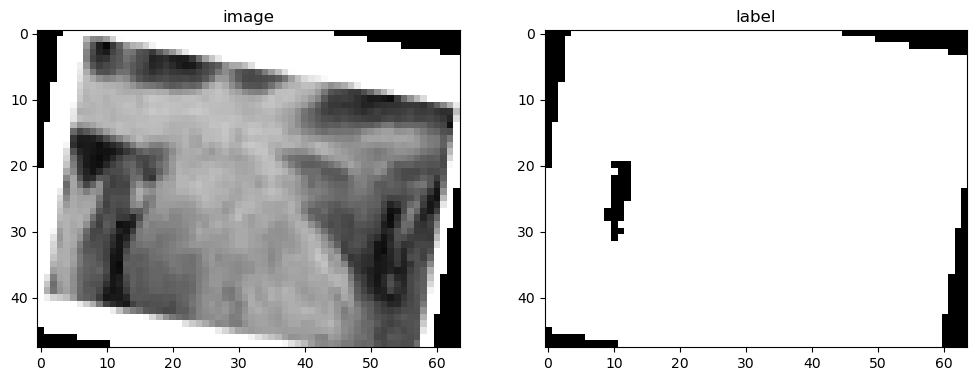

In [7]:
# visualize a training example from train_loader
batch = next(iter(train_data_loader))

batch_image = batch["image"]["data"]
batch_label = batch["label"]["data"]

print(f"The shape of the data is {batch_image.shape}")

plot_image_label(batch_image, batch_label, slice_idx=30)

# Define the model

In [8]:
# U-Net model from monai
model = monai.networks.nets.UNet(
    dimensions=3,
    in_channels=1,
    out_channels=3,
    channels=(8, 16, 32, 64),
    strides=(2, 2, 2),
)

# dice cross entropy loss
criterion = monai.losses.DiceCELoss(softmax=True)

# AdamW optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=config["lr"])

# device for gpu or cpu training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

c:\Users\simon\anaconda3.gz\envs\torch-v2-gpu\lib\site-packages\monai\utils\deprecate_utils.py:219: FutureWarning: monai.networks.nets.unet UNet.__init__:dimensions: Argument `dimensions` has been deprecated since version 0.6. Please use `spatial_dims` instead.
  warn_deprecated(argname, msg, warning_category)


# Training Loop

First define the Trainer object and then call Trainer.training_loop!

In [9]:
# defining the trainer object
trainer = Trainer(
    train_data_loader=train_data_loader,
    val_data_loader=val_data_loader,
    device=device,
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    **config
)

Nit is set to 8, training will stop after 8 iterations each epoch...

Trainer summary:
  -Model: UNet
  -Loss function: DiceCELoss
  -Optimizer: AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    weight_decay: 0.01
)
  -Device: cuda
  -Epochs: 10
  -Early stopping: -1
  -Train from checkpoint: None
  -Fine tune: False
  -Best models dir: best_models
  -Mixed precision: True
  -Nit: 8
  -Random seed: 42



In [10]:
# track training time
import time

print(f"Mixed precision: {config['mixed_precision']}")

times_1 = []
for _ in range(10):
    start_time = time.time()
    # starting the training loop
    trainer.training_loop()
    end_time = time.time()
    times_1.append(end_time - start_time)

print(f"Average training time: {sum(times_1) / len(times_1)}")

Mixed precision: True
Starting training...

Epoch 1/10, train loss: 0.9931, val loss: 0.9351
Epoch 2/10, train loss: 0.7475, val loss: 0.7216
Epoch 3/10, train loss: 0.6873, val loss: 0.6464
Epoch 4/10, train loss: 0.6185, val loss: 0.5751
Epoch 5/10, train loss: 0.5756, val loss: 0.5321
Epoch 6/10, train loss: 0.5497, val loss: 0.5090
Epoch 7/10, train loss: 0.5583, val loss: 0.4993
Epoch 8/10, train loss: 0.5052, val loss: 0.4773
Epoch 9/10, train loss: 0.4787, val loss: 0.4594
Epoch 10/10, train loss: 0.4589, val loss: 0.4533

Best validation loss: 0.4533
Saving the last model...
Starting training...

Epoch 1/10, train loss: 0.4501, val loss: 0.4226
Epoch 2/10, train loss: 0.3929, val loss: 0.3700
Epoch 3/10, train loss: 0.3340, val loss: 0.3083
Epoch 4/10, train loss: 0.3182, val loss: 0.2687
Epoch 5/10, train loss: 0.2632, val loss: 0.2342
Epoch 6/10, train loss: 0.2676, val loss: 0.2457
Epoch 7/10, train loss: 0.2713, val loss: 0.2316
Epoch 8/10, train loss: 0.2526, val loss: 0.2

In [13]:
# config["mixed_precision"] = not(config["mixed_precision"])
trainer.mixed_precision = not(trainer.mixed_precision)
print(f"Mixed precision: {trainer.mixed_precision}")

times_2 = []
for _ in range(10):
    start_time = time.time()
    # starting the training loop
    trainer.training_loop()
    end_time = time.time()
    times_2.append(end_time - start_time)

print(f"Average training time: {sum(times_2) / len(times_2)}")

Mixed precision: False
Starting training...

Epoch 1/10, train loss: 0.1691, val loss: 0.1769
Epoch 2/10, train loss: 0.1601, val loss: 0.1796
Epoch 3/10, train loss: 0.1727, val loss: 0.1703
Epoch 4/10, train loss: 0.1694, val loss: 0.1693
Epoch 5/10, train loss: 0.1881, val loss: 0.1768
Epoch 6/10, train loss: 0.1809, val loss: 0.1886
Epoch 7/10, train loss: 0.1776, val loss: 0.1764
Epoch 8/10, train loss: 0.1636, val loss: 0.1864
Epoch 9/10, train loss: 0.1723, val loss: 0.1854
Epoch 10/10, train loss: 0.1874, val loss: 0.1755

Best validation loss: 0.1693
Saving the last model...
Starting training...

Epoch 1/10, train loss: 0.1644, val loss: 0.1712
Epoch 2/10, train loss: 0.1790, val loss: 0.1899
Epoch 3/10, train loss: 0.1774, val loss: 0.1750
Epoch 4/10, train loss: 0.1582, val loss: 0.1785
Epoch 5/10, train loss: 0.1678, val loss: 0.1787
Epoch 6/10, train loss: 0.1638, val loss: 0.1753
Epoch 7/10, train loss: 0.1950, val loss: 0.1779
Epoch 8/10, train loss: 0.1657, val loss: 0.

In [14]:
print(f"Speedup: {sum(times_1) / len(times_1) / (sum(times_2) / len(times_2))}")
print(times_1)
print(times_2)

Speedup: 0.9844833000597715
[124.81179690361023, 123.06061005592346, 124.92455124855042, 125.77011299133301, 125.38619685173035, 123.58568072319031, 126.8952910900116, 128.45547604560852, 126.72262334823608, 130.9973282814026]
[126.21548628807068, 126.77132487297058, 131.18803596496582, 129.23030018806458, 130.8431966304779, 128.70458722114563, 128.8739197254181, 126.04116606712341, 125.2091715335846, 127.40127921104431]


# Testing the results

# Fine-tuning thoughts

To understand how to fine tune the model, I decided to print the model structure and shapes of the parameters it is made of. Then I saw that the last 2 sets of parameters corresponded to the last ConvTranspose3d and the corresponding bias, with shapes `torch.Size([16, 3, 3, 3, 3])` and `torch.Size([3])`. 

Hence I decided to freeze all the other weights and only keep thos for the fine-tuning.

In [ ]:
model

In [ ]:
for param in list(model.parameters()):
    print(param.shape)